In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.functional import normalize  # noqa: F401
import torch.nn.functional as F

from torch.autograd import Variable

import pyro
from pyro.distributions import Normal, Bernoulli  # noqa: F401
from pyro.infer import SVI
from pyro.optim import Adam

pyro.get_param_store().clear()

In [7]:
data = pd.read_csv('data/ethusd_tweets.csv')[::-1]

In [4]:
data.head()

Date      Open      High       Low     Close   Volume Market Cap  \
898  Aug 07 2015  2.830000  3.540000  2.520000  2.770000   164329          -   
897  Aug 08 2015  2.790000  2.800000  0.714725  0.753325   674188  167911000   
896  Aug 09 2015  0.706136  0.879810  0.629191  0.701897   532170   42637600   
895  Aug 10 2015  0.713989  0.729854  0.636546  0.708448   405283   43130000   
894  Aug 11 2015  0.708087  1.130000  0.663235  1.070000  1463100   42796500   

     Average (High + Low / 2)  Tweets  
898                      3.03     NaN  
897                      1.76     NaN  
896                      0.75     NaN  
895                      0.68     NaN  
894                      0.90     NaN

In [10]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)
def forward(self, x):
        # x * w + b
        return self.linear(x)

In [32]:
def return_last_n_days_numeric(N, data, column_name):
    return pd.to_numeric(data.iloc[-N:][column_name])

In [41]:
N = 360 #days

highp = return_last_n_days_numeric(N, data, 'High')
lowp = return_last_n_days_numeric(N, data, 'Low')
openp = return_last_n_days_numeric(N, data, 'Open')
closep = return_last_n_days_numeric(N, data, 'Close')

tweets = return_last_n_days_numeric(N, data, 'Tweets').replace('null', 0)
volume = return_last_n_days_numeric(N, data, 'Volume')
marketcap = return_last_n_days_numeric(N, data, 'Market Cap')

normal_close = closep

In [42]:
highp = highp.pct_change().replace(np.nan, 0).replace(np.inf, 0)
lowp = lowp.pct_change().replace(np.nan, 0).replace(np.inf, 0)
openp = openp.pct_change().replace(np.nan, 0).replace(np.inf, 0)
closep = closep.pct_change().replace(np.nan, 0).replace(np.inf, 0)
tweets = tweets.pct_change().replace(np.nan, 0).replace(np.inf, 0)
volume = volume.pct_change().replace(np.nan, 0).replace(np.inf, 0)
marketcap = marketcap.pct_change().replace(np.nan, 0).replace(np.inf, 0)

normal_close = np.array(normal_close)
highp = np.array(highp)
lowp = np.array(lowp)
openp = np.array(openp)
closep = np.array(closep)
tweets = np.array(tweets)
volume = np.array(volume)
marketcap = np.array(marketcap)

In [43]:
WINDOW = 7
STEP = 1
FORECAST = 1

X, Y = [], []
for i in range(0, len(openp), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volume[i:i+WINDOW]
        t = tweets[i:i+WINDOW]
        m = marketcap[i:i+WINDOW]
        
#         y_i = (normal_close[i+WINDOW+FORECAST] - normal_close[i+WINDOW]) / normal_close[i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]
        x_i = np.column_stack((o, h, l, c, v, t, m))
        x_i = x_i.flatten()

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)

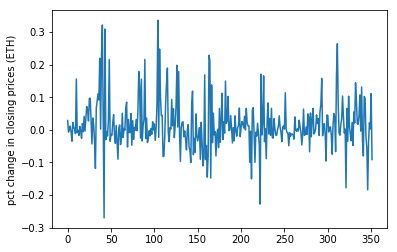

In [51]:
plt.figure()
plt.plot(Y)
plt.ylabel('pct change in closing prices (ETH)')
plt.show()

In [53]:
X_train, Y_train = Variable(torch.Tensor(X[:-30])), Variable(torch.Tensor(Y[:-30]))
X_test, Y_test = Variable(torch.Tensor(X[-30:])), Variable(torch.Tensor(Y[-30:]))
data = torch.cat((X_train, Y_train), 1)

In [54]:
# get array of batch indices
def get_batch_indices(N, batch_size):
    all_batches = np.arange(0, N, batch_size)
    if all_batches[-1] != N:
        all_batches = list(all_batches) + [N]
    return all_batches

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.predict(x)
        return x

first_layer = len(X_train.data.numpy()[0])
second_layer = 25   
    
softplus = nn.Softplus()
regression_model = Net(first_layer, second_layer)

In [55]:
def model(data):

    mu = Variable(torch.zeros(second_layer, first_layer)).type_as(data)
    sigma = Variable(torch.ones(second_layer, first_layer)).type_as(data)
    bias_mu = Variable(torch.zeros(second_layer)).type_as(data)
    bias_sigma = Variable(torch.ones(second_layer)).type_as(data)
    w_prior, b_prior = Normal(mu, sigma), Normal(bias_mu, bias_sigma)
    
    mu2 = Variable(torch.zeros(1, second_layer)).type_as(data)
    sigma2 = Variable(torch.ones(1, second_layer)).type_as(data)
    bias_mu2 = Variable(torch.zeros(1)).type_as(data)
    bias_sigma2 = Variable(torch.ones(1)).type_as(data)
    w_prior2, b_prior2 = Normal(mu2, sigma2), Normal(bias_mu2, bias_sigma2)    
    
    priors = {'hidden.weight': w_prior, 
              'hidden.bias': b_prior,
              'predict.weight': w_prior2,
              'predict.bias': b_prior2}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    with pyro.iarange("map", N, subsample=data):
        x_data = data[:, :-1]
        y_data = data[:, -1]
        # run the regressor forward conditioned on inputs
        prediction_mean = lifted_reg_model(x_data).squeeze()
        pyro.sample("obs",
                    Normal(prediction_mean, Variable(torch.ones(data.size(0))).type_as(data)),
                    obs=y_data.squeeze())